To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# VAWT Unsteady BEM

***Note: The mean Cp and CT in the concluding plot is slightly off from Given Solution, but I am not sure how that was calculated. I took the last 360 points which should be one revolution, and took the average of the values of those data points.***


This exercise deals with a Vertical Axis Wind Turbine, VAWT and how to estimate the time dependent
loads using an unsteady BEM approach, as described in the lecture notes.

$R=3m$, $Vo=8m/s$, $ω=12 rad/s$, $B=2$, $ρ=1.225 kg/m3$, $θp=0$, $S=B∙c/R=0.2$. The airfoil data are given in the
file airfoil.txt.

Q#1: Compute and plot as function of time $pt,B=1$, $px,tot$, $py,tot$, $CT$ and $Cp$. Wait until the solution becomes
periodic and estimate the time averaged $CT$ and $Cp$. $px,tot(t)$ and $py,tot(t)$ are the sum of the loads from all blades at time, t, in x and y direction, respectively and is the load felt by the tower. $pt,B=1(t)$ is the tangential load experienced by only blade #1.

Q#2: Now add one blade so B=3, but keep the solidity at S=0.2. Plot px,tot, py,tot and explain the
difference in the loads experienced by the tower. Compare the time averaged CT and Cp with the 2
bladed VAWT having the same solidity.

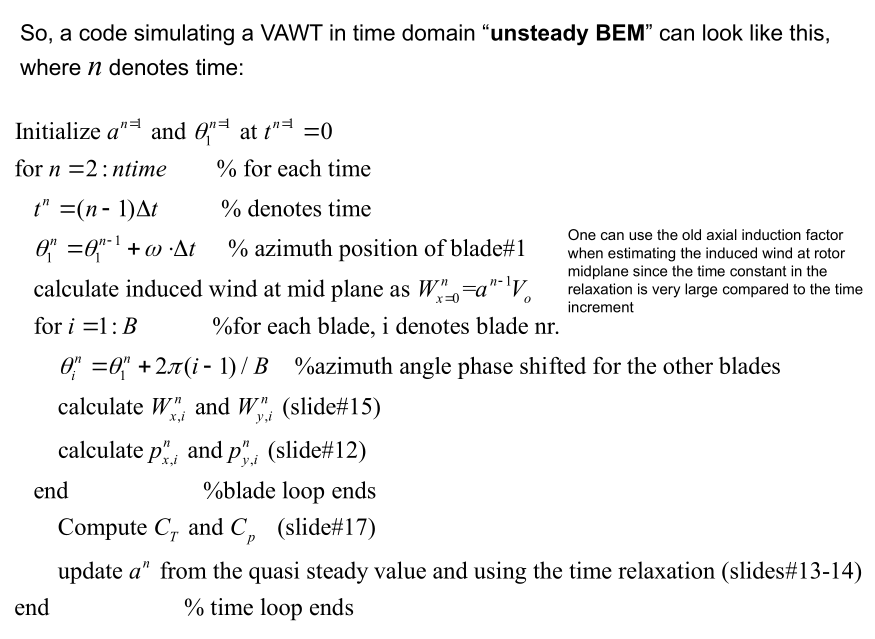

$n$, iteration number

$a$: Induction factor

$\theta_1$: Azimuth position of blade 1

$\omega$: rotational speed

$W_{x=0}^n$: Induced wind speed at mid plane.

$W_{x, i]^n$:

$W_{y=0}^n$: Induced wind speed at mid plane

$B$: number of blades

10 rotations should be enough to reach steady state. I choose 1 degree between every point/iteration.

In [423]:
from colorsys import yiq_to_rgb

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Airfoil data
The airfoil data is given, but I have to interpolate between angles to get the lift and drag coefficients

In [424]:
airfoil_data = pd.read_csv("airfoil.txt", sep='\s+', header=None, comment='#')
airfoil_data.columns = ['AoA', 'Cl', 'Cd']
airfoil_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_15097/2015589082.py:1: SyntaxWarning: invalid escape sequence '\s'
  airfoil_data = pd.read_csv("airfoil.txt", sep='\s+', header=None, comment='#')


,AoA,Cl,Cd
0,-90.0,0.00,2.00
1,-80.0,-0.35,1.95
2,-70.0,-0.73,1.90
3,-60.0,-1.06,1.70
4,-50.0,-1.27,1.40


In [425]:
# How to interpolate with numpy
np.interp(-75, airfoil_data['AoA'], airfoil_data['Cl'])

np.float64(-0.54)

### Variables and Unsteady BEM Coding

$\lambda = tsr = \frac{\omega R}{V_0}$

lambda = 4.5

In [426]:
R = 3       # [m]
V0 = 8      # [m/s]
omega = 12  # [rad/s]
B = 2       # [-]
rho = 1.225 # [kg / m³]
theta_p = 0 # [rad]
S = 0.2     # [-], solidity
tau = 2 * R / V0
revolutions = 10

d_theta = np.deg2rad(1) # [rad]
steps_revolution = (2 * np.pi / d_theta)
steps_total = steps_revolution * revolutions # revs. pr. second times steps pr. revolution times revolutions
t_revolution = 2 * np.pi / omega
dt = t_revolution / steps_revolution
ntime = int(steps_total)

print("d_theta", d_theta)
print("steps_total", steps_total)

d_theta 0.017453292519943295
steps_total 3600.0


In [427]:

R = 3       # [m]
V0 = 8      # [m/s]
omega = 12  # [rad/s]
B = 2       # [-]
rho = 1.225 # [kg / m³]
theta_p = 0 # [rad]
S = 0.2     # [-], solidity
tau = 2 * R / V0
revolutions = 20

In [428]:

d_theta = np.deg2rad(1) # [rad]
steps_revolution = (2 * np.pi / d_theta)
steps_total = steps_revolution * revolutions # revs. pr. second times steps pr. revolution times revolutions
t_revolution = 2 * np.pi / omega
dt = t_revolution / steps_revolution
ntime = int(steps_total)

print("d_theta", d_theta)
print("steps_total", steps_total)
print("dt", dt)

d_theta 0.017453292519943295
steps_total 7200.0
dt 0.0014544410433286077


In [429]:

a = 0
theta = np.zeros([B, ntime]) # Azimuth position of blades

#theta = np.zeros(B)
Wx = np.zeros([B, ntime])
Wy = np.zeros([B, ntime])
px = np.zeros([B, ntime])
py = np.zeros([B, ntime])
pt = np.zeros([B, ntime])
pn = np.zeros([B, ntime])
xi = np.zeros([B, ntime])
yi = np.zeros([B, ntime])


CT = np.zeros(ntime)
Cp = np.zeros(ntime)

t = np.zeros(ntime)
a = np.zeros(ntime) # a is calculated in the middle, and weighed depending on which blade we calculate for


for n in range(1, ntime):
    tn = (n - 1) * dt
    t[n] = tn
    theta[:, n] = theta[:, n - 1] + omega * dt

    # Induced wind speed at mid plane
    for i in range(B):
        theta[i, n] = theta[0, n] + 2 * np.pi / B * i  # accounting for MATLAB notation in slides
        Wx[i, n] = a[n - 1] * V0 * (1 - 0.4 * np.sin(theta[i, n]))
        Wy[i, n] = 0.4 * Wx[i, n] * np.cos(theta[i, n])

        # loads(?)
        xi[i, n] = - R * np.sin(theta[i, n])
        yi[i, n] = R * np.cos(theta[i, n]) # I changed the fortegn
        Vrelxi = omega * yi[i, n] + V0 - Wx[i, n]
        Vrelyi = - omega * xi[i, n] + Wy[i, n]
        Vnormi = (V0 - Wx[i, n]) * np.sin(theta[i, n]) - Wy[i, n] * np.cos(theta[i, n])
        Vtani = (V0 - Wx[i, n]) * np.cos(theta[i, n]) + Wy[i, n] * np.sin(theta[i, n]) + omega * R
        V2reli = Vnormi**2 + Vtani**2
        phii = np.atan(Vnormi / Vtani)
        alphai = phii - theta_p
        # Interpolated airfoil data
        Cl = np.interp(np.rad2deg(alphai), airfoil_data['AoA'], airfoil_data['Cl'])
        Cd = np.interp(np.rad2deg(alphai), airfoil_data['AoA'], airfoil_data['Cd'])
        c = S * R / B # c is chord length, derived from solidity
        li = 1/2 * rho * V2reli * c * Cl
        di = 1/2 * rho * V2reli * c * Cd
        pn[i, n] = li * np.cos(phii) + di * np.sin(phii)
        pt[i, n] = li * np.sin(phii) - di * np.cos(phii)
        px[i, n] = pn[i, n] * np.sin(theta[i, n]) - pt[i, n] * np.cos(theta[i, n])
        py[i, n] = - pn[i, n] * np.cos(theta[i, n]) - pt[i, n] * np.sin(theta[i, n])

    CT[n] = np.sum(px[:, n]) / (rho * V0**2 * R)
    Cp[n] = omega * np.sum(pt[:, n]) / (rho * V0**3)

    aqs = 0.246 * CT[n] + 0.0586 * CT[n]**2 + 0.0883 * CT[n]**3
    a[n] = aqs + (a[n - 1] - aqs) * np.exp(-dt / tau)

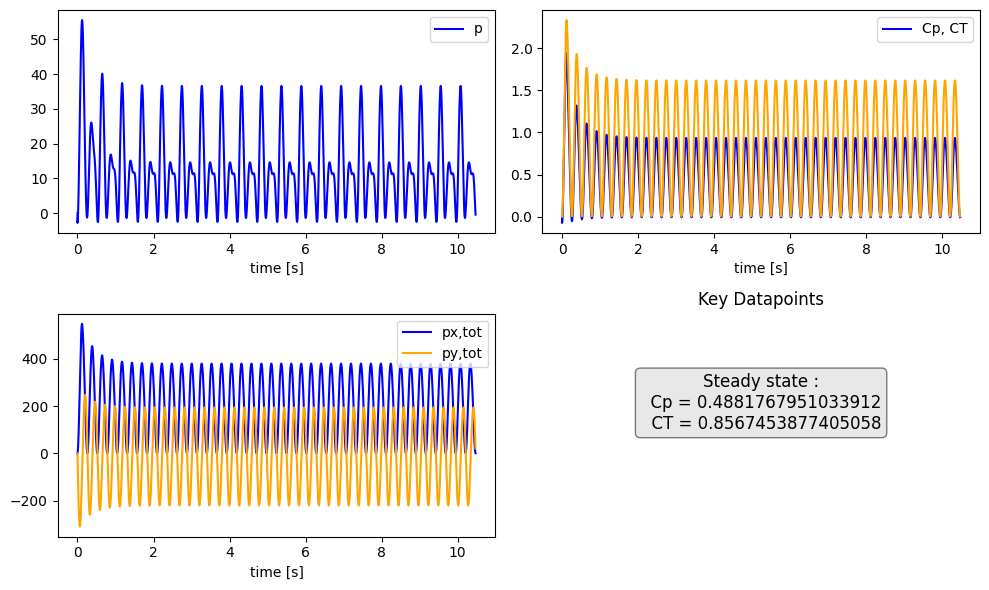

In [430]:


# Create a 2x1 grid for the right column (two plots)
# and a 2x1 grid for the left column (one plot spanning both rows)
fig = plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Left column: 1 plot (spans both rows)
ax1 = plt.subplot2grid((2, 2), (0, 0))  # (rows, cols), (start_row, start_col), rowspan=2
ax1.plot(t, pt[0, :], color='blue')
ax1.set_xlabel('time [s]')
ax1.legend('pt B=1')

px_tot = px[0, :] + px[1, :]
py_tot = py[0, :] + py[1, :]
# Left column: 1 plot (spans both rows)
ax2 = plt.subplot2grid((2, 2), (1, 0))  # (rows, cols), (start_row, start_col), rowspan=2
ax2.plot(t, px_tot[:], color='blue')
ax2.plot(t, py_tot[:], color='orange')
ax2.set_xlabel('time [s]')
ax2.legend(['px,tot', 'py,tot'])

# Right column: Top plot
ax3 = plt.subplot2grid((2, 2), (0, 1))  # (rows, cols), (start_row, start_col)
ax3.plot(t, Cp, color='blue')
ax3.plot(t, CT, color='orange')
ax3.set_xlabel('time [s]')
ax3.legend(['Cp, CT'])


# Steady state values
Cp_ss = np.mean(Cp[:-360])
CT_ss = np.mean(CT[:-360])

# Right column: Bottom "plot" (replaced with text)
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.text(0.5, 0.6, f'Steady state :\n  Cp = {Cp_ss}\n  CT = {CT_ss}',  # Text content (use `\n` for newlines)
         ha='center', va='center', fontsize=12,  # Horizontal/vertical alignment
         bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round'))  # Styling
ax4.set_title('Key Datapoints')
ax4.axis('off')  # Hide axes for a clean text box

# Adjust layout to prevent overlap
plt.tight_layout()

# Plots used for debuggin

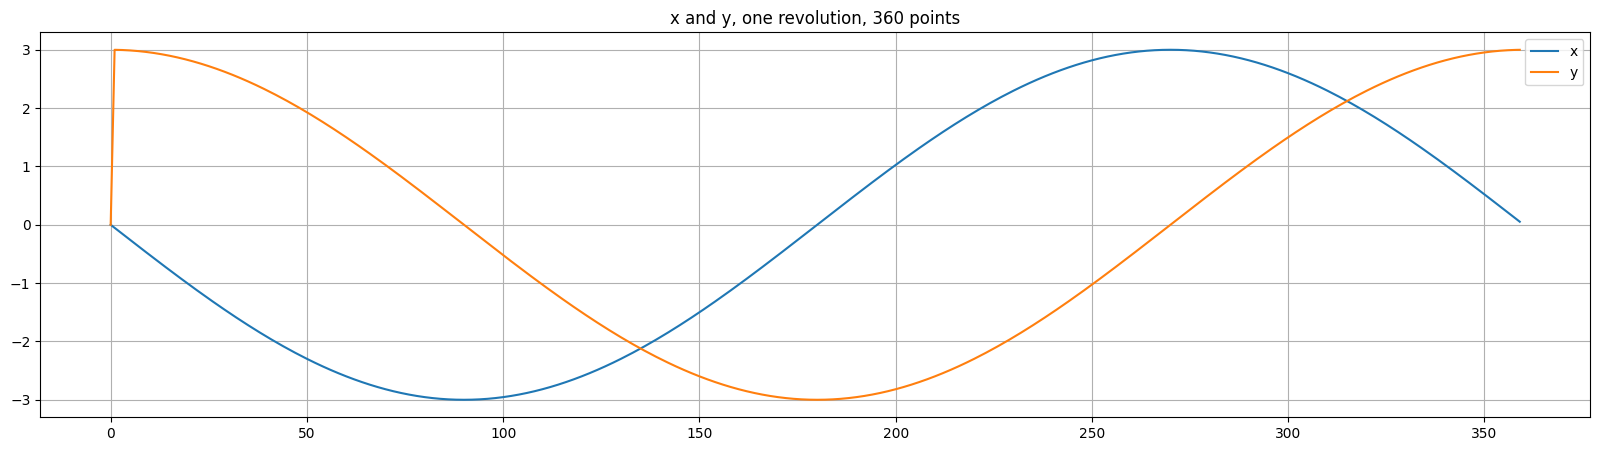

In [431]:
plt.figure(figsize=(20, 5))
plt.plot(xi[0, 0:360])
plt.plot(yi[0, 0:360])
plt.grid(True)
plt.title('x and y, one revolution, 360 points')
plt.legend(['x', 'y'])

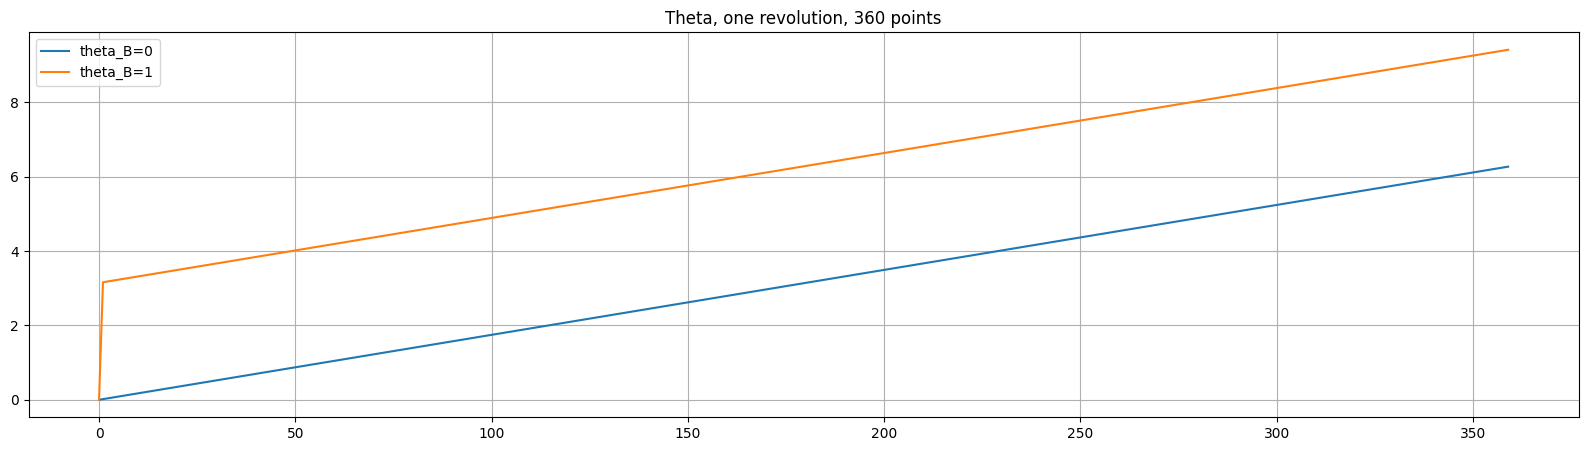

In [432]:
plt.figure(figsize=(20, 5))
plt.plot(theta[0, 0:360])
plt.plot(theta[1, 0:360])
plt.grid(True)
plt.title('Theta, one revolution, 360 points')
plt.legend(['theta_B=0', 'theta_B=1'])

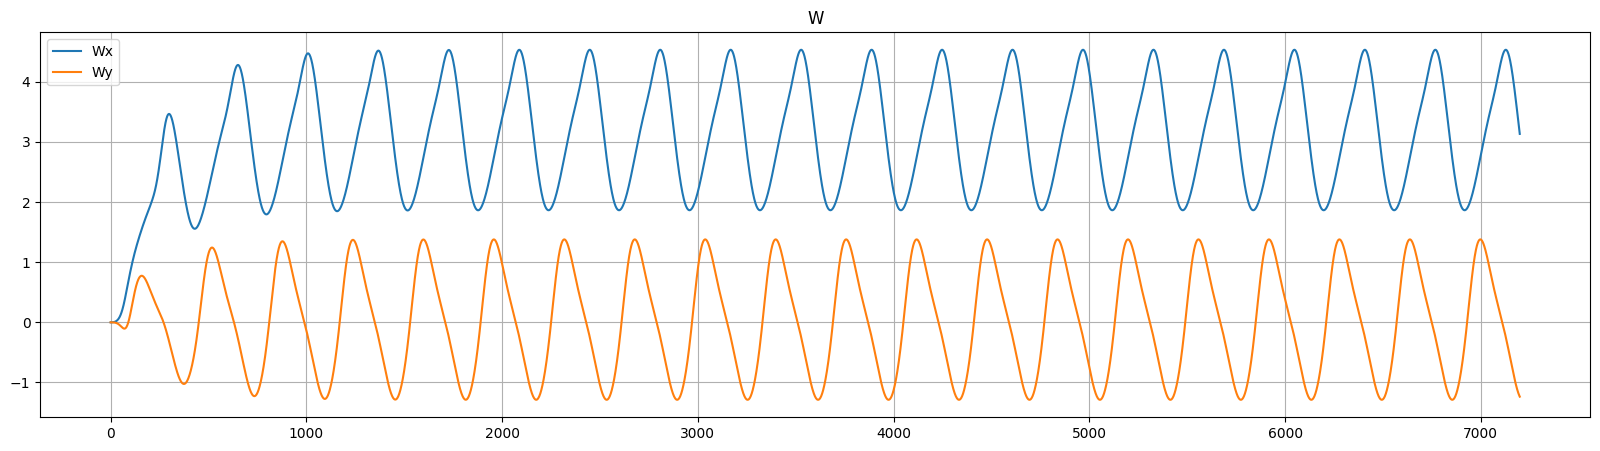

In [433]:
plt.figure(figsize=(20, 5))
plt.plot(Wx[0, :])
plt.plot(Wy[1, :])
plt.grid(True)
plt.title('W')
plt.legend(['Wx', 'Wy'])

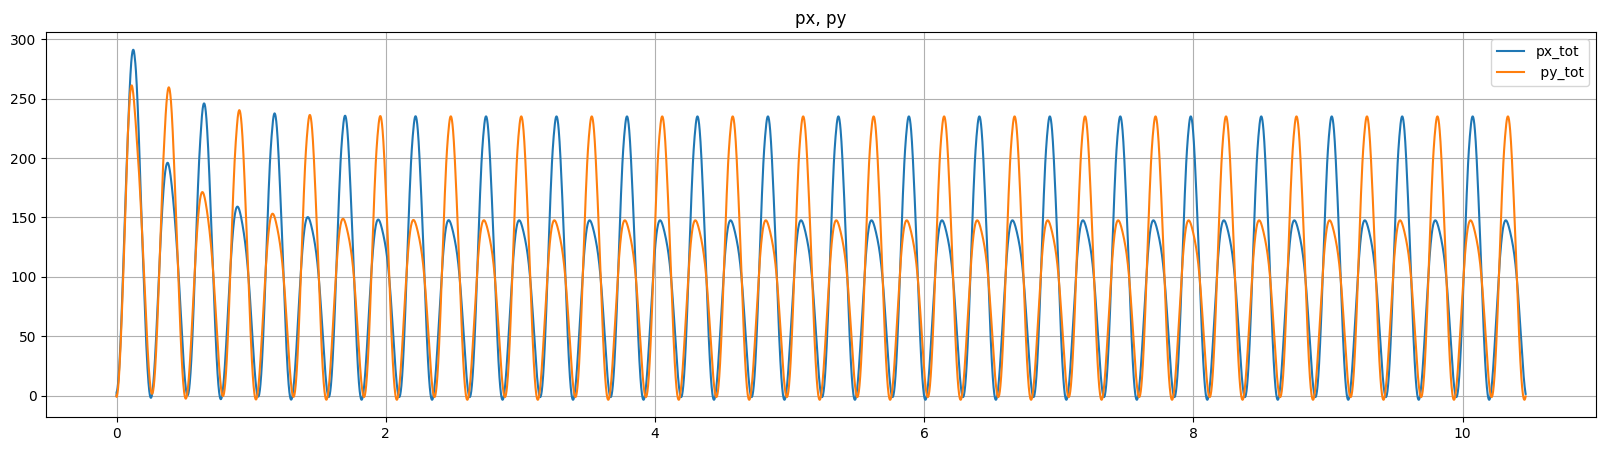

In [434]:
px_tot = px[0, :] + px[1, :]
py_tot = py[0, :] + py[1, :]
plt.figure(figsize=(20, 5))
plt.plot(t, px[0, :])
plt.plot(t, px[1, :])
#plt.plot(pt[0, :])
#plt.plot(pt[1, :])
plt.grid(True)
plt.title('px, py')
plt.legend(['px_tot',' py_tot'])
#plt.legend(['px_tot',' py_tot',' pt1',' pt2'])

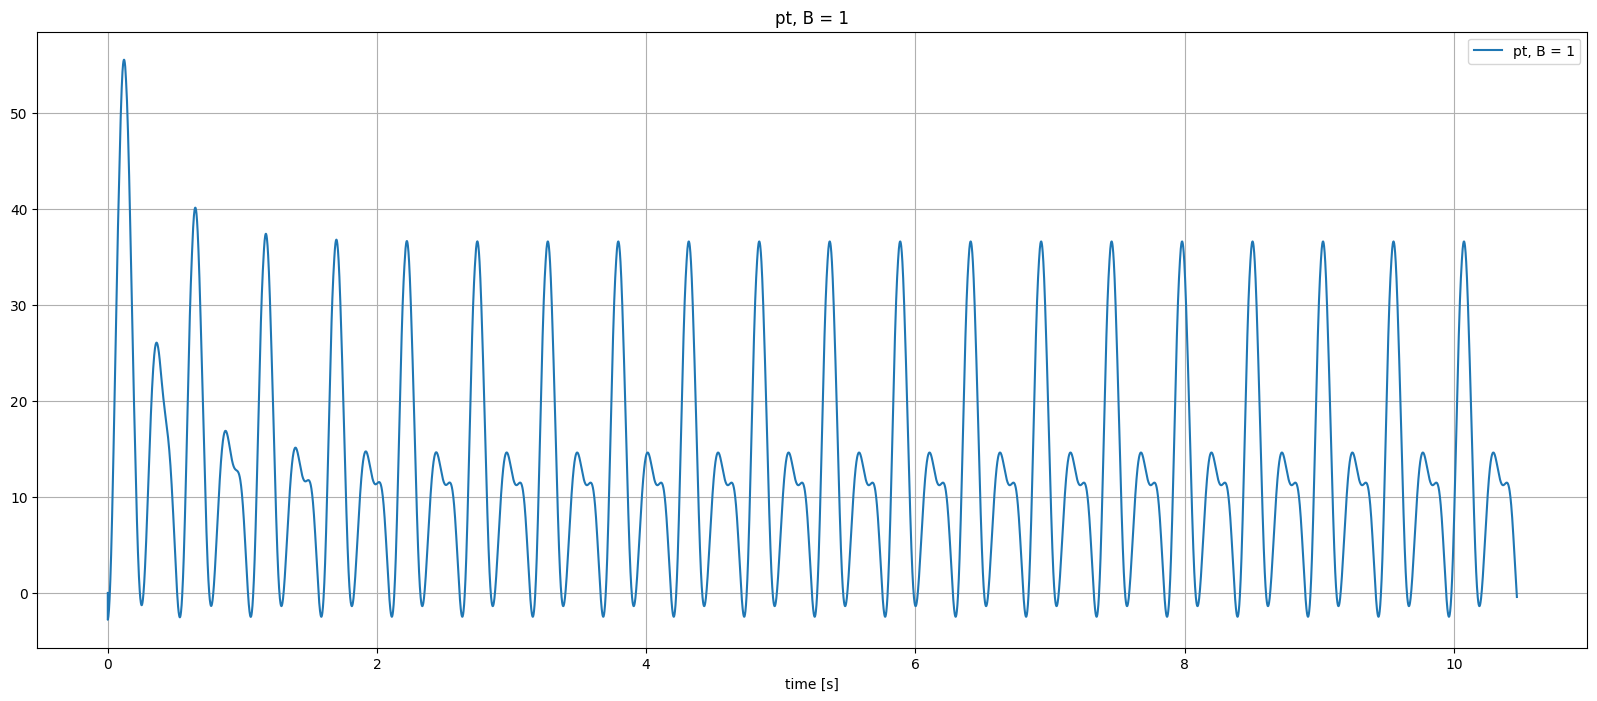

In [435]:
plt.figure(figsize=(20, 8))
plt.plot(t, pt[0])
plt.grid(True)
plt.xlabel('time [s]')
plt.title('pt, B = 1')
plt.legend(['pt, B = 1'])

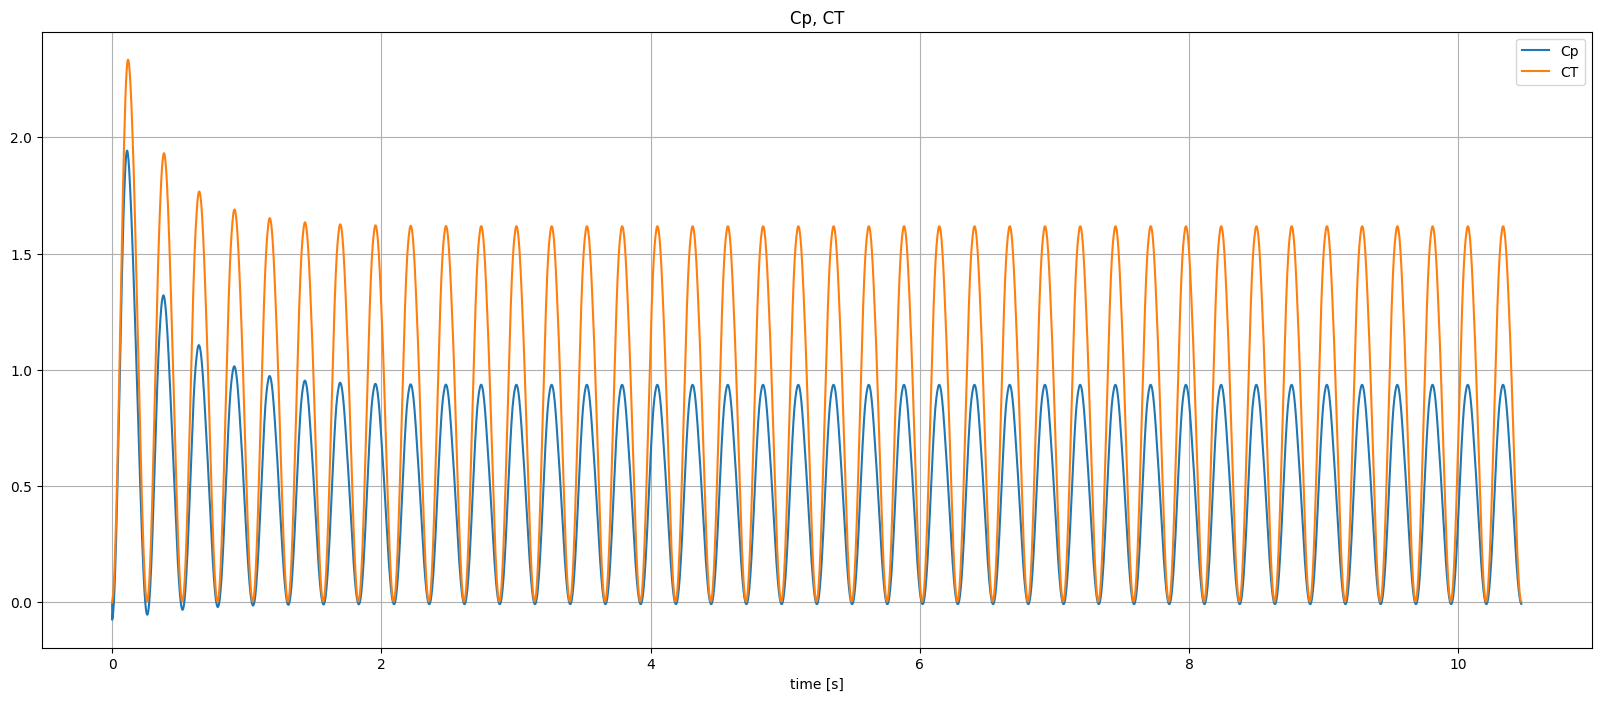

In [436]:
plt.figure(figsize=(20, 8))
plt.plot(t, Cp)
plt.plot(t, CT)
plt.grid(True)
plt.xlabel('time [s]')
plt.title('Cp, CT')
plt.legend(['Cp', 'CT'])

Text(0.5, 1.0, 'a, one revolution, 360 points')

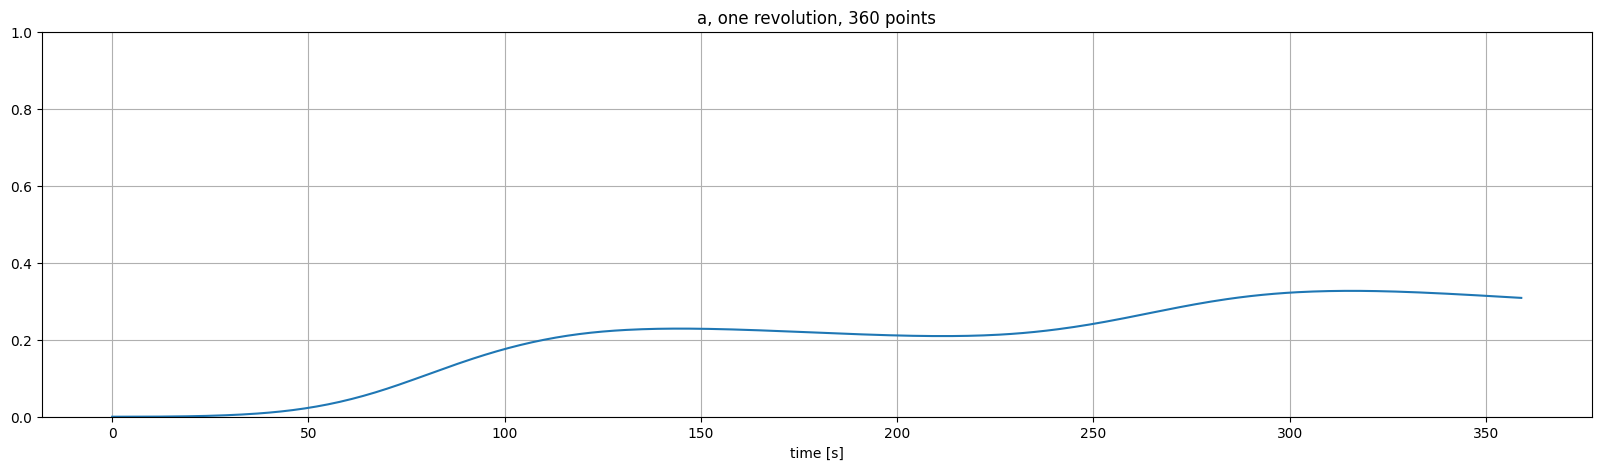

In [437]:
plt.figure(figsize=(20, 5))
plt.plot(a[0:360])
plt.grid(True)
plt.xlabel('time [s]')
plt.ylim([0, 1])
plt.title('a, one revolution, 360 points')

Text(0.5, 1.0, 'a')

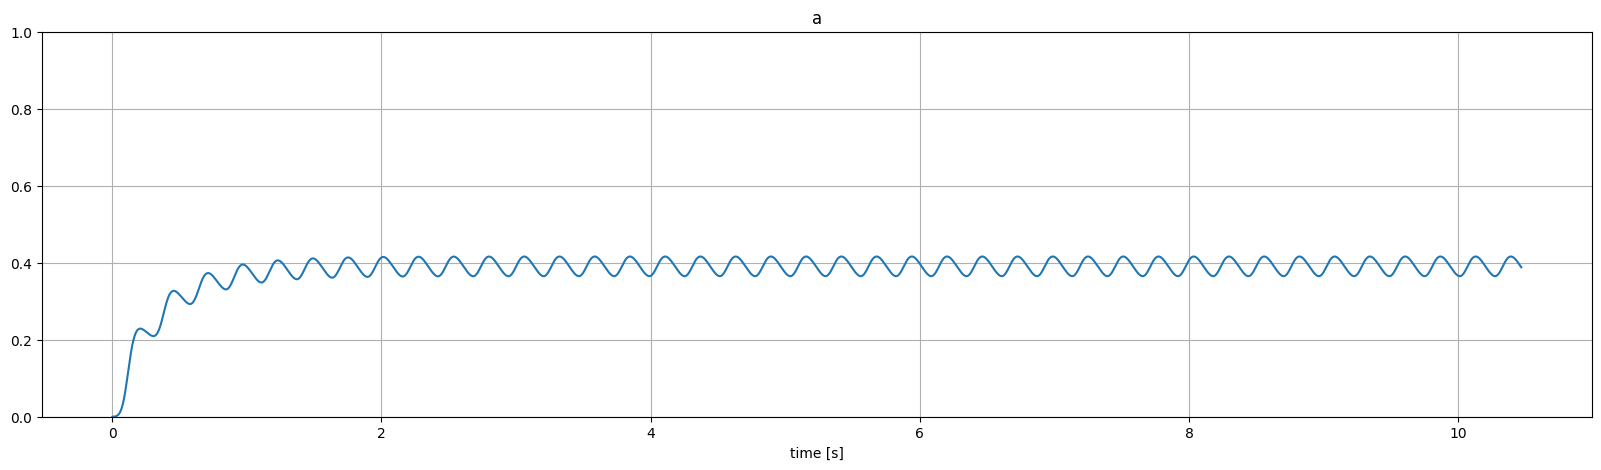

In [438]:
plt.figure(figsize=(20, 5))
plt.plot(t, a)
plt.grid(True)
plt.xlabel('time [s]')
plt.ylim([0, 1])
plt.title('a')